# Anomaly-Based Intrusion Detection: Model Training and Evaluation

This Jupyter Notebook details the next stage of my project, building upon the preprocessed CICIDS2017 dataset prepared [here](https://www.kaggle.com/code/ericanacletoribeiro/cicids2017-comprehensive-data-processing-for-ml). This stage focuses on training and evaluating several supervised and unsupervised machine learning models for anomaly-based intrusion detection. The goal is to identify which algorithms perform most effectively in this context, considering both detection accuracy and computational efficiency, crucial for resource-constrained environments.

The project aims to build a Network Intrusion Detection System (NIDS) prototype capable of identifying a range of network attacks, including DoS, PortScan and Brute Force. The effectiveness of the chosen algorithms will be assessed using a variety of metrics, including accuracy, precision, recall, F1-score, ROC-AUC, and resource usage (CPU time and memory consumption).

**Models Being Evaluated:**

* **Supervised Learning:**
    * Random Forest
    * XGBoost
    * Support Vector Machine (SVM)

* **Unsupervised Learning:**
    * Isolation Forest
    * K-Means Clustering

**Evaluation Strategy:**

Model performance will be rigorously evaluated using k-fold cross-validation on the training data, with a separate hold-out test set used for final model assessment. Resource utilization (CPU and memory) will be monitored during training and testing to assess the efficiency of the algorithms in resource-constrained scenarios.

This notebook will present the training process, hyperparameter tuning, performance evaluation, and a comparative analysis of the selected models, providing insights into the most suitable algorithms for anomaly-based intrusion detection in resource-constrained networks. The final goal is to select the best performing model to be integrated into the NIDS prototype.

In [1]:
# Importing the relevant libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# 1. Loading and Verifying

In [2]:
# Loading the datasets
scaled_df = pd.read_csv('/kaggle/input/cicids2017_scaled.csv')
clean_df = pd.read_csv('/kaggle/input/cicids2017_cleaned.csv')

In [3]:
# Quick look at the datasets
scaled_df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,...,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Max,Active Min,Idle Mean,Idle Max,Idle Min,Attack Type
0,-0.148718,0.227972,9.75,8.11875,2.122449,-0.054054,0.624470,1.480798,1.187838,0.0,...,1.029661,7.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal Traffic
1,-0.148718,0.237913,9.75,8.11875,2.122449,-0.054054,0.624470,1.480798,1.187838,0.0,...,1.029661,7.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal Traffic
2,-0.148718,-0.009462,-0.25,-0.20625,-0.204082,-0.054054,-0.788043,0.000000,-0.131081,0.0,...,1.029661,-0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal Traffic
3,-0.148718,0.234938,9.75,8.31875,2.122449,-0.054054,0.658404,1.484375,1.187838,0.0,...,1.029661,7.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal Traffic
4,90.553846,-0.009478,-0.25,-0.20625,-0.204082,-0.054054,-0.788043,0.000000,-0.131081,0.0,...,1.228814,-0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal Traffic


In [4]:
# Quick look at the datasets
clean_df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,...,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Max,Active Min,Idle Mean,Idle Max,Idle Min,Attack Type
0,22,1266342,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
1,22,1319353,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
2,22,160,1,0,0,0,0.000000,0.000000,0,0,...,243,0,32,0.0,0,0,0.0,0,0,Normal Traffic
3,22,1303488,41,2728,456,0,66.536585,110.129945,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
4,35396,77,1,0,0,0,0.000000,0.000000,0,0,...,290,0,32,0.0,0,0,0.0,0,0,Normal Traffic


## 1.1. Preparing Training and Test Sets

In [5]:
# Checking the distribution of the target variable
clean_df['Attack Type'].value_counts()

Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64

The dataset shows a considerable imbalance, as already discussed in the [previous notebook](https://www.kaggle.com/datasets/ericanacletoribeiro/cicids2017-cleaned-and-preprocessed). Since cross-validation results are already available without addressing this imbalance (serving as a benchmark), the decision here is to undersample the majority class to reduce complexity while aiming to maintain performance. This can help the model pay more attention to the less frequent attack types, which are often the focus in intrusion detection systems.

In [6]:
# Preparing training and test splits
X_scaled = scaled_df.drop('Attack Type', axis=1)
y_scaled = scaled_df['Attack Type']

X_clean = clean_df.drop('Attack Type', axis=1)
y_clean = clean_df['Attack Type']

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42, stratify=y_scaled)

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, y_clean, test_size=0.3, random_state=42, stratify=y_clean)

Applying undersampling from imbalanced-learn

In [7]:
# Initializing the undersampling
X_train_under, y_train_under = RandomUnderSampler(sampling_strategy={'Normal Traffic': 500000}, random_state=42).fit_resample(X_train_clean, y_train_clean)

X_train_under_scaled, y_train_under_scaled = RandomUnderSampler(sampling_strategy={'Normal Traffic': 500000}, random_state=42).fit_resample(X_train_scaled, y_train_scaled)

In order to further balance the training set, we can also partialy oversample the minority classes with SMOTE. _Synthetic Minority Over-sampling Technique_ is a widely-used method to address class imbalance in datasets by generating synthetic samples for the minority class, rather than merely duplicating existing ones.

In [8]:
# Initializing the oversampling
X_train_resampled, y_train_resampled = SMOTE(sampling_strategy={'Bots': 2000, 'Web Attacks': 2000, 'Brute Force': 7000, 'Port Scanning': 70000}, random_state=42).fit_resample(X_train_under, y_train_under)

X_train_resampled_scaled, y_train_resampled_scaled = SMOTE(sampling_strategy={'Bots': 2000, 'Web Attacks': 2000, 'Brute Force': 7000, 'Port Scanning': 70000}, random_state=42).fit_resample(X_train_under_scaled, y_train_under_scaled)

In [9]:
# Checking the distribution of the attack types in the resampled dataset
y_train_resampled.value_counts()

Attack Type
Normal Traffic    500000
DoS               135621
DDoS               89610
Port Scanning      70000
Brute Force         7000
Bots                2000
Web Attacks         2000
Name: count, dtype: int64

# 2. Supervised Learning

## 2.1. Random Forest

Random Forest is robust to variance in the data. Therefore, it can be trained on the non-scaled version of the dataset without a significant impact on performance.

In [10]:
# Creating the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Fitting the model
rf.fit(X_train_resampled, y_train_resampled)

# Cross validation
cv_scores = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=5)

# Making predictions
y_pred_clean = rf.predict(X_test_clean)

In [11]:
# Evaluating the model performance on the cross validation set vs accuracy on the test set
cv_scores_mean = np.mean(cv_scores)
print(f'Cross validation average score: {cv_scores_mean:.4f} +/- standard deviation: {np.std(cv_scores):.4f}')

accuracy = accuracy_score(y_test_clean, y_pred_clean)
print(f'Accuracy on the test set: {accuracy:.4f}')

Cross validation average score: 0.9986 +/- standard deviation: 0.0001
Accuracy on the test set: 0.9987


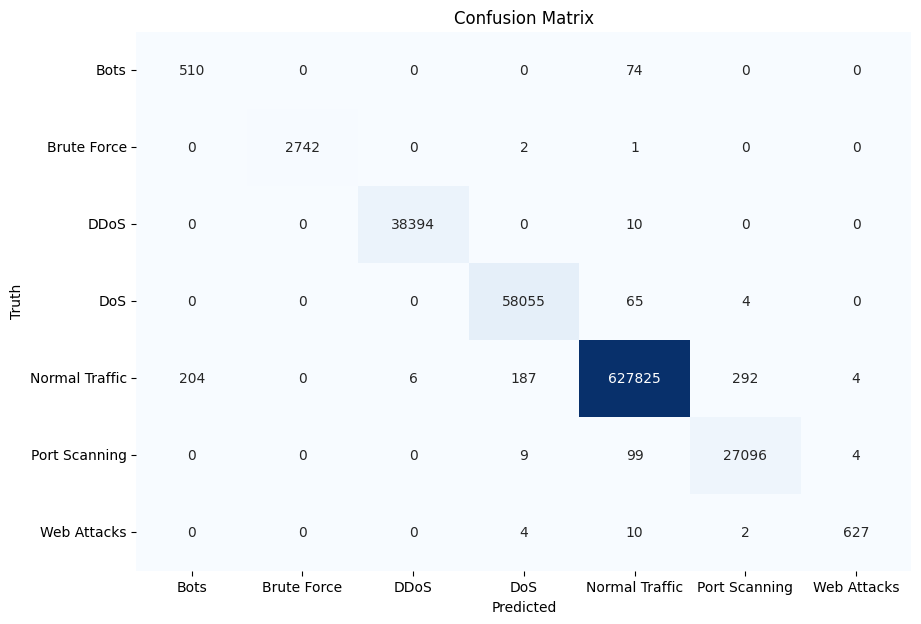

In [12]:
# Evaluating the model via confusion matrix
cm = confusion_matrix(y_test_clean, y_pred_clean)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=rf.classes_, yticklabels=rf.classes_, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

In [13]:
print(classification_report(y_test_clean, y_pred_clean))

                precision    recall  f1-score   support

          Bots       0.71      0.87      0.79       584
   Brute Force       1.00      1.00      1.00      2745
          DDoS       1.00      1.00      1.00     38404
           DoS       1.00      1.00      1.00     58124
Normal Traffic       1.00      1.00      1.00    628518
 Port Scanning       0.99      1.00      0.99     27208
   Web Attacks       0.99      0.98      0.98       643

      accuracy                           1.00    756226
     macro avg       0.96      0.98      0.97    756226
  weighted avg       1.00      1.00      1.00    756226



With a mean cross-validation score of 0.9986 and an accuracy score of 0.9987, the model demonstrates strong performance without signs of underfitting or overfitting. Additionally, the confusion matrix reveals a significant improvement in recall (from 0.50 to 0.88) and F1-score (from 0.63 to 0.79) for the 'Bots' class compared to the benchmark model ([available here](https://www.kaggle.com/code/ericanacletoribeiro/cicids2017-comprehensive-data-processing-for-ml)).
While the precision score for the 'Bots' class decreased from 0.86 to 0.71, the trade-off is justified in the context of a NIDS. In such systems, minimizing false negatives is crucial, as undetected threats can compromise network security. False positives, while inconvenient, are less harmful than false negatives. This improvement in recall indicates that the model is now better at detecting 'Bots' attacks, validating the effectiveness of resampling techniques for this dataset.
Additionally, although additional steps, such as incorporating class weights, could further enhance the model's performance, these optimizations are better suited for advanced algorithms like XGBoost, which is the next technique we explore in our analysis.

## 2.2. XGBoost